# BCycle all-data Models 

This notebook uses the cleaned data for all trips from the opening of BCycle in 2013 through to the end of 2016. The data provide from BCycle is split into two normalized tables:

## `all_trips_clean.csv`

This is the time-varying trips table, and has the following columns:

* `datetime`: Time the trip began in YYYY-MM-DD HH:MM:SS format. The resolution is 1 minute, i.e. SS is always 00.
* `membership`: Categorical column with memebrship type.
* `bike_id`: Integer ID of the bike used for a trip
* `checkout_id`: ID of the station where the bike was checked out (links to stations table).
* `checkin_id`: ID of the station where the bike was checked in (links to stations table).
* `duration`: The length of the trip in minutes


## `all_stations_clean.csv`

This contains the static station information for all 

* `address`: Station address
* `lat`: Station latitude
* `lon`: Station longitude
* `name`: Station Name
* `station_id`: Station unique identifier (ID), used to link to trips table



## Imports and data loading

Before getting started, let's import some useful libraries for visualization, and the bcycle utils library.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Helper functions

Before getting started on the data analysis, let's define a few useful functions we can call to plot data and reproduce the same analysis.

# Load station and trip data

The `notebooks/bcycle_all_data_eda` notebook cleans up the raw CSV file from BCycle, and splits it into a stations and trips dataframe. Because of this, the clean CSV files read in below shouldn't need too much processing. The `bcycle_lib` library contains the functions to load and clean the data.

In [2]:
from bcycle_lib.all_utils import load_bcycle_data

print('Loading stations and trips....', end='')
stations_df, trips_df = load_bcycle_data('../input', 'all_stations_clean.csv', 'all_trips_clean.csv', verbose=False)
print('done!')
print('Bike trips loaded from {} to {}'.format(trips_df.index[0], trips_df.index[-1]))

print('\nStations DF info:')
stations_df.info()
print('\nTrips DF info:')
trips_df.info()

Loading stations and trips....done!
Bike trips loaded from 2013-12-21 09:09:00 to 2016-12-31 23:43:02

Stations DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
address       67 non-null object
lat           67 non-null float32
lon           67 non-null float32
name          67 non-null object
station_id    67 non-null uint8
dtypes: float32(2), object(2), uint8(1)
memory usage: 1.7+ KB

Trips DF info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548158 entries, 2013-12-21 09:09:00 to 2016-12-31 23:43:02
Data columns (total 5 columns):
membership     548158 non-null category
bike_id        548158 non-null uint16
checkout_id    548158 non-null uint8
checkin_id     548158 non-null uint8
duration       548158 non-null uint16
dtypes: category(1), uint16(2), uint8(2)
memory usage: 7.8 MB


# Load weather data

When we train the models, we'll use weather data to add some extra information for the model to learn from. With a little bit of investigation we can form our own URLs to get data ranges. Here's a typical URL


```
March 8th to September 21st:
https://www.wunderground.com/history/airport/KATT/2013/3/8/CustomHistory.html?dayend=21&monthend=9&yearend=2013&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```
From this example we can piece together where each of the day, month, and year fields come for the start and end time ranges. For example 

```
MM/DD/YYYY to MM2/DD2/YYYY

https://www.wunderground.com/history/airport/KATT/<YYYY>/<MM>/<DD>/CustomHistory.html?dayend=<DD2>&monthend=<MM2>&yearend=<YYYY>&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

```

Let's make a function that takes two dates, and returns a pandas dataframe of the weather between these. The API only returns up to a year at-a-time, so we'll make multiple calls if there are multiple years.

In [3]:
import requests
import io

def weather_url_from_dates(start_date, end_date):
    '''Creates a URL string to fetch weather data between dates
    INPUT: start_date - start date for weather
           end_date - end date for weather
    RETURNS: string of the URL 
    '''
    assert start_date.year == end_date.year, 'Weather requests have to use same year'
    
    url = 'https://www.wunderground.com/history/airport/KATT/'
    url += str(start_date.year) + '/' 
    url += str(start_date.month) + '/'
    url += str(start_date.day) + '/'
    url += 'CustomHistory.html?dayend=' + str(end_date.day)
    url += '&monthend=' + str(end_date.month)
    url += '&yearend=' + str(end_date.year)
    url += '&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=&format=1'
    
    return url

def weather_from_df_dates(df, verbose=False):
    '''Returns a dictionary of weather dataframes, one per year
    INPUT: Dataframe with date index
    RETURNS : Dataframe of corresponding weather information
    '''
    yearly_weather = list()
    unique_years = set(trips_df.index.year)
    sorted_years = sorted(unique_years, key=int)
    
    for year in sorted_years:
        year_df = trips_df[str(year)]
        start_date = year_df.index[0]
        end_date = year_df.index[-1]
        year_url = weather_url_from_dates(start_date, end_date)
        if verbose:
            print('Year {}: start date {}, end date {}'.format(year, start_date, end_date))
#             print('URL: {}'.format(year_url))

        if verbose: print('Fetching CSV data ... ', end='')
        req = requests.get(year_url).content
        req_df = pd.read_csv(io.StringIO(req.decode('utf-8')))
        yearly_weather.append(req_df)
        if verbose: print('done')
            
    combined_df = pd.concat(yearly_weather)
    return combined_df

weather_df = weather_from_df_dates(trips_df, verbose=True)
print('weather_df shape: {}'.format(weather_df.shape))

Year 2013: start date 2013-12-21 09:09:00, end date 2013-12-31 23:18:00
Fetching CSV data ... done
Year 2014: start date 2014-01-01 00:12:00, end date 2014-12-31 23:19:00
Fetching CSV data ... done
Year 2015: start date 2015-01-01 00:08:00, end date 2015-12-31 23:37:35
Fetching CSV data ... done
Year 2016: start date 2016-01-01 00:18:49, end date 2016-12-31 23:43:02
Fetching CSV data ... done
weather_df shape: (1107, 23)


# Cleaning weather data

There are some missing values in the weather data. For numeric ones like the Dew Point and Humidity, we'll forward-fill the NA values. For `Events`, a missing value means there wasn't an event on that day, so we don't want to forward fill and add events that didn't happen on that day.

In [4]:
from bcycle_lib.all_utils import clean_weather
# Let's check the data for missing values, and forward-fill
# print('Initial Weather missing value counts:')
# print(weather_df.isnull().sum(axis=0))

for col in weather_df.columns:
    if 'Events' not in col:
        weather_df[col] = weather_df[col].fillna(method='pad')

print('\nAfter forward-filling NA values (apart from Events):')
print(weather_df.isnull().sum(axis=0))


After forward-filling NA values (apart from Events):
CST                             0
Max TemperatureF                0
Mean TemperatureF               0
Min TemperatureF                0
Max Dew PointF                  0
MeanDew PointF                  0
Min DewpointF                   0
Max Humidity                    0
 Mean Humidity                  0
 Min Humidity                   0
 Max Sea Level PressureIn       0
 Mean Sea Level PressureIn      0
 Min Sea Level PressureIn       0
 Max VisibilityMiles            0
 Mean VisibilityMiles           0
 Min VisibilityMiles            0
 Max Wind SpeedMPH              0
 Mean Wind SpeedMPH             0
 Max Gust SpeedMPH              0
PrecipitationIn                 0
 CloudCover                     0
 Events                       754
 WindDirDegrees<br />           0
dtype: int64


### Save weather out to CSV

For repeatability we can save out the weather data we just downloaded to a CSV file. First of all we need to clean up the columns, and then we can write it out.

In [5]:
from bcycle_lib.all_utils import clean_weather

weather_df = clean_weather(weather_df)
weather_df.to_csv('../input/all_weather.csv')

/Users/tim/projects/bcycle-austin/notebooks/bcycle_lib/all_utils.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')


# Time-based linear model

Let's kick off by creating a linear model based on time features.

In [6]:
from bcycle_lib.all_utils import add_time_features

TRAIN_START = '2014-01-01'
TRAIN_END = '2016-05-31'
VAL_START = '2016-06-01'
VAL_END = '2016-12-31'

hourly_trips_df = trips_df.resample('1H').size().to_frame(name='count')
hourly_trips_df = add_time_features(hourly_trips_df)
train_df = hourly_trips_df[TRAIN_START:TRAIN_END]
val_df = hourly_trips_df[VAL_START:VAL_END]

n_train = train_df.shape[0]
n_val = val_df.shape[0]
n_total = n_train + n_val
n_train_pct = (n_train / n_total) * 100.0
n_val_pct = (n_val / n_total) * 100.0

print('\nTraining data first and last row:\n{}\n{}'.format(train_df.index[0], train_df.index[-1]))
print('\nValidation data first and last row:\n{}\n{}\n'.format(val_df.index[0], val_df.index[-1]))

print('Train data shape: {}, {:.2f}% of rows'.format(train_df.shape, n_train_pct))
print('Validation data shape: {}, {:.2f}% of rows'.format(val_df.shape, n_val_pct))


Training data first and last row:
2014-01-01 00:00:00
2016-05-31 23:00:00

Validation data first and last row:
2016-06-01 00:00:00
2016-12-31 23:00:00

Train data shape: (21168, 6), 80.47% of rows
Validation data shape: (5136, 6), 19.53% of rows


# Visualizing hourly rentals

Now we can visualize the training and validation rental data separately. To keep the graphs clear, we'll resample according to the length of data we're dealing with. The training data is from 2014, 2015, and the first half of 2016. The validation data is from the second half of 2016.

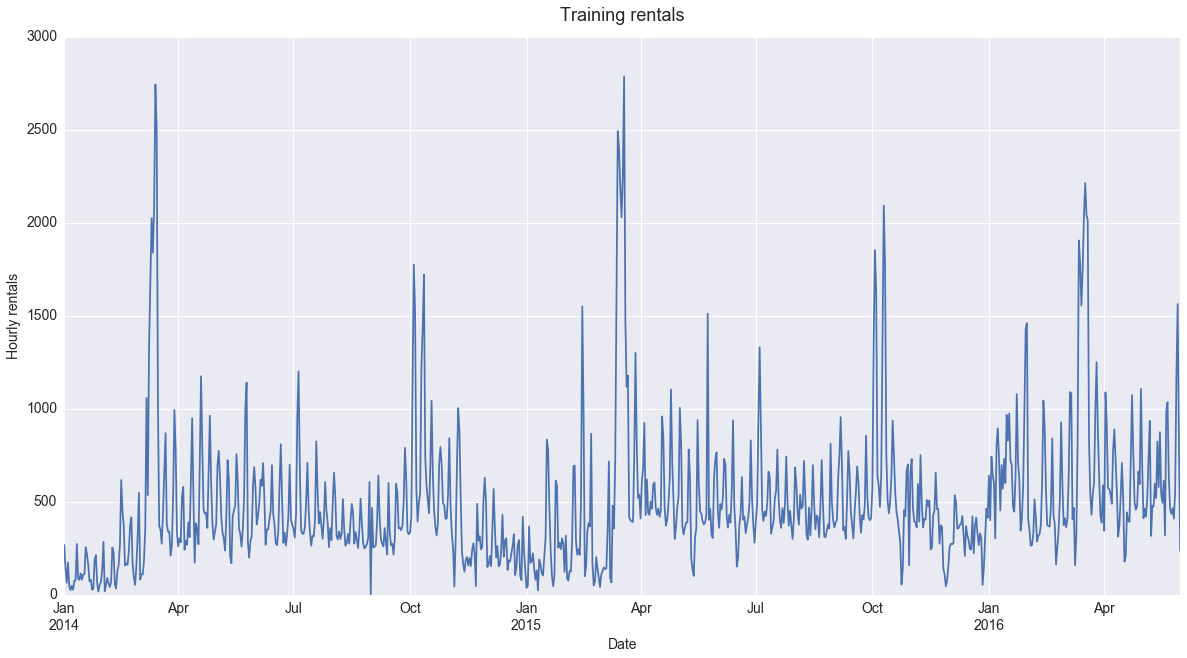

In [7]:
from bcycle_lib.all_utils import plot_lines

plot_df = train_df.resample('1D').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Training rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

The graph shows a single approximately week-long spike in March (during SXSW) of 2750 - 2250 trips. There are also  two sharp peaks a week apart in October (during ACL) of 1750-2000 daily trips. 

After these peaks, there are other days with between 1000 and 1500 trips. There's one in mid-Feb, one towards the end of April, one at the end of May, and another at the start of July. These most likely correspond to national holidays. 

For these special cases, we'll need to add in extra dummy variables to help models work out why the amount of trips suddenly peaks.

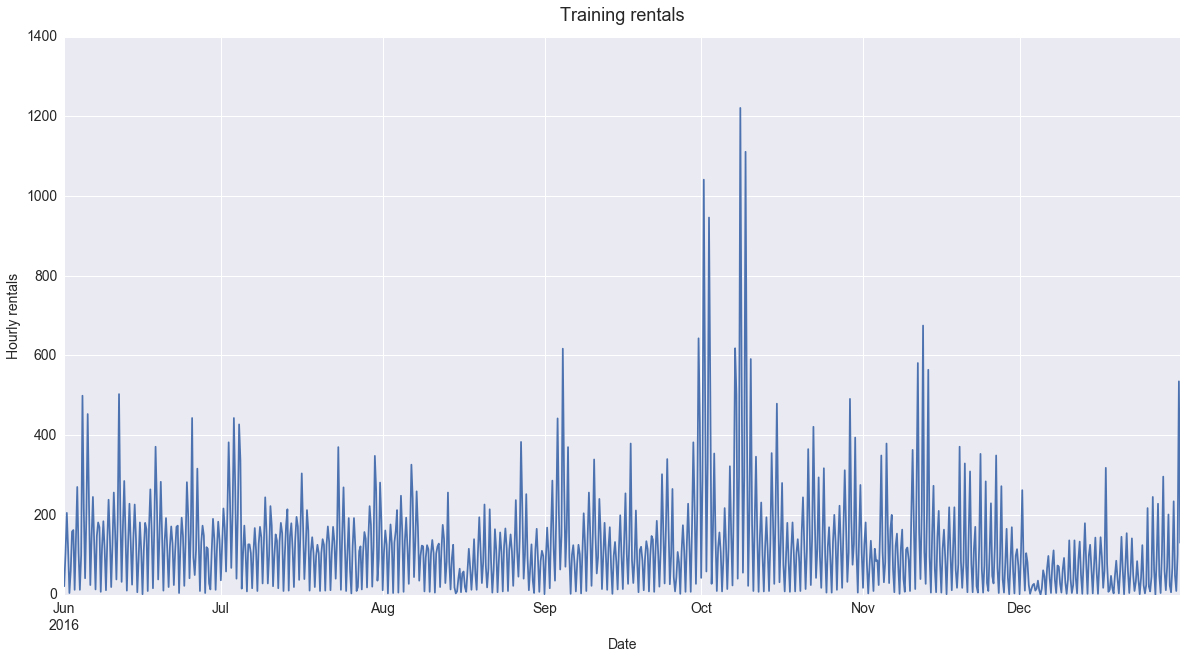

In [8]:
# Let's plot the validation
plot_df = val_df.resample('6H').sum()['count']

plot_lines(plot_df, plt.subplots(1,1,figsize=(20,10)), 
                                 title='Training rentals', 
                                 xlabel='Date', ylabel='Hourly rentals')

The 6-month period of the validation data allows us to see multiple levels of periodicity in the data. The shortest is the daily period. The weekly period is also visible, with most weeks ending in higher levels of trips on Friday, Saturday, and Sunday. 

There are also some special events which are one-off. The spike at the start of September is probably due to the Labor Day holiday, and the one at the end of November is likely Thanksgiving. The two largest peaks are the first two weekends in October, and these correspond to ACL.

# Distributions in training and validation datasets

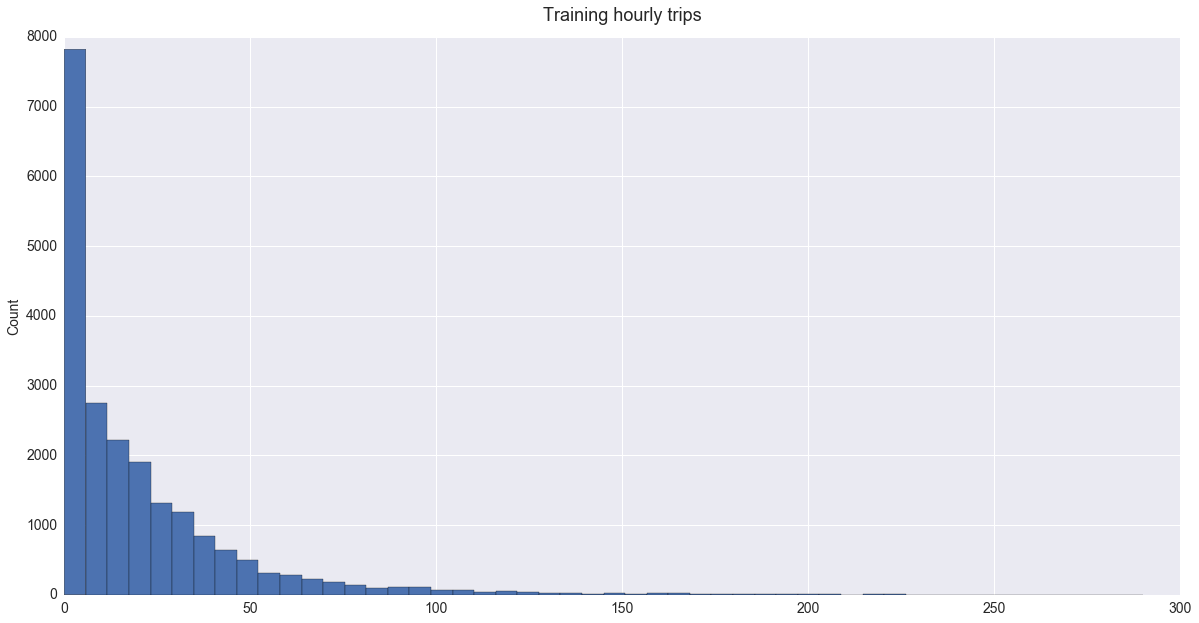

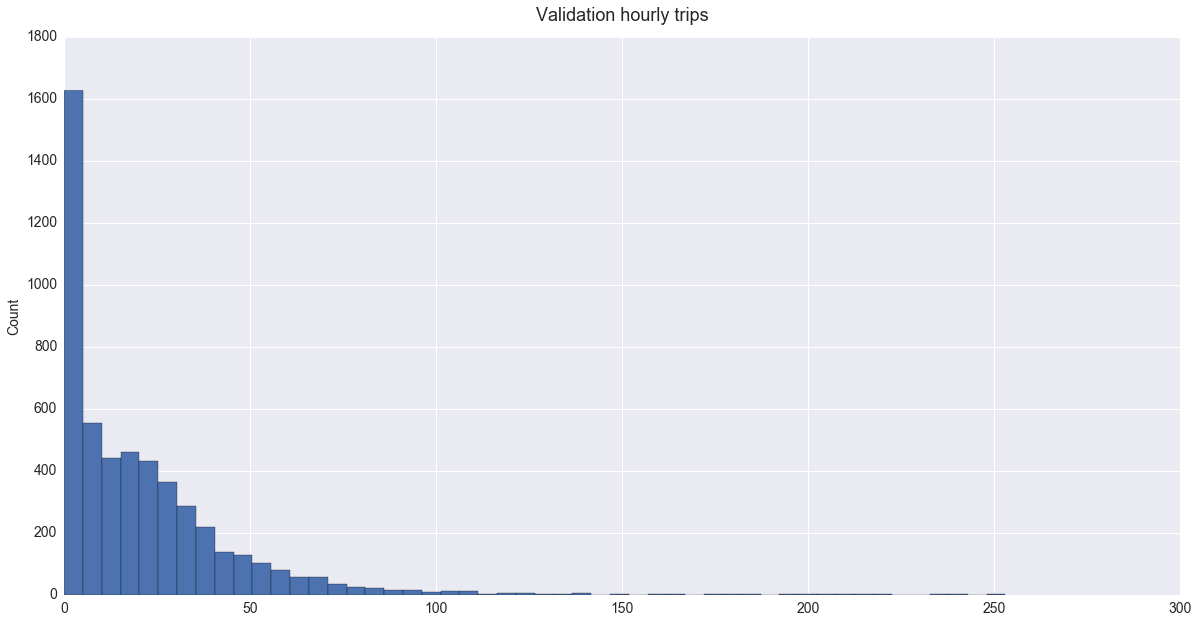

In [9]:
from bcycle_lib.all_utils import plot_hist
plot_hist(train_df['count'], bins=50, size=(20,10), title='Training hourly trips', xlabel='', ylabel='Count')
plot_hist(val_df['count'], bins=50, size=(20,10), title='Validation hourly trips', xlabel='', ylabel='Count')



# Baseline linear model

Now we have inspected some of the data, let's create a baseline linear model using time features.

In [10]:
# First create a daily rentals dataframe, split it into training and validation
from bcycle_lib.all_utils import add_time_features

linreg_train_df = add_time_features(train_df)
linreg_val_df = add_time_features(val_df)

print('Training data shape: {}'.format(linreg_train_df.shape))
print('Validation data shape: {}'.format(linreg_val_df.shape))

/Users/tim/anaconda/envs/ds450_env/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Training data shape: (21168, 6)
Validation data shape: (5136, 6)


In [11]:
# Now we need to split into X and y
from bcycle_lib.all_utils import reg_x_y_split

X_train, y_train, _ = reg_x_y_split(linreg_train_df[['day-hour', 'count']], 
                                           target_col='count', 
                                           ohe_cols=['day-hour'])
X_val, y_val, _ = reg_x_y_split(linreg_val_df[['day-hour', 'count']], 
                                     target_col='count', 
                                     ohe_cols=['day-hour'])

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {}, y_val shape: {}'.format(X_val.shape, y_val.shape))

Binarizing column day-hour
Binarizing column day-hour
X_train shape: (21168, 168), y_train shape: (21168,)
X_val shape: (5136, 168), y_val shape: (5136,)


Linear reg baseline RMSE - Train: 21.38, Val: 16.77


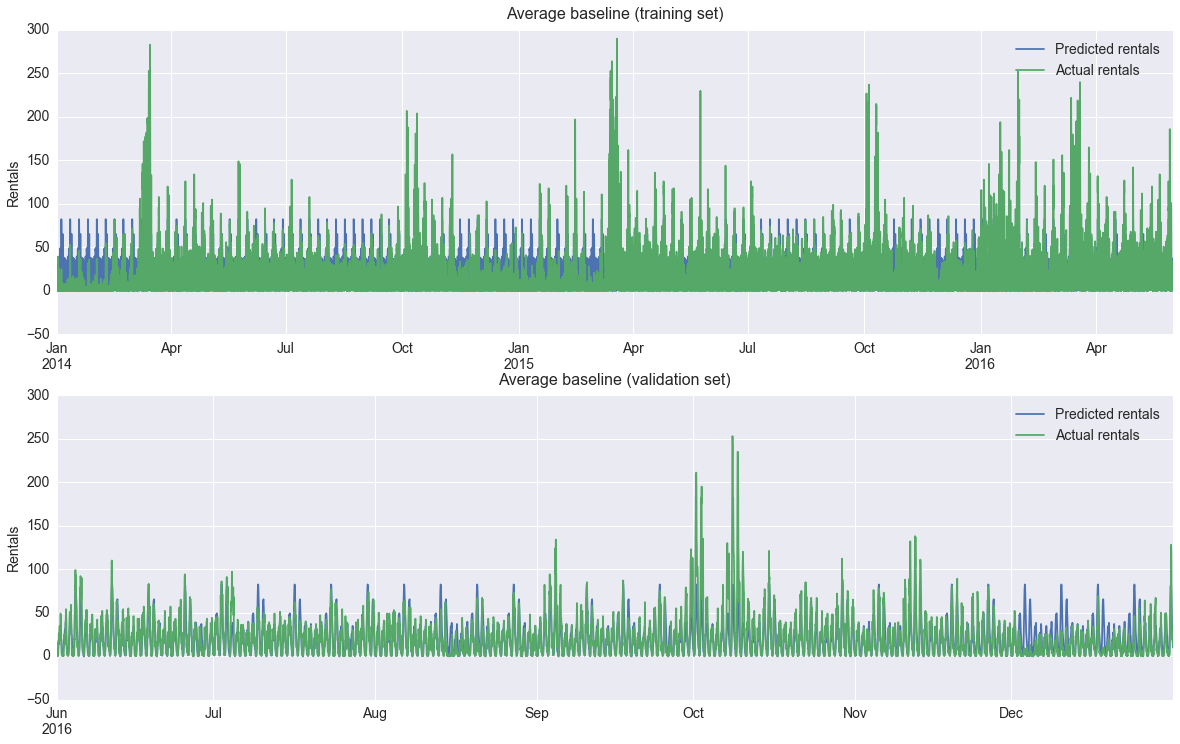

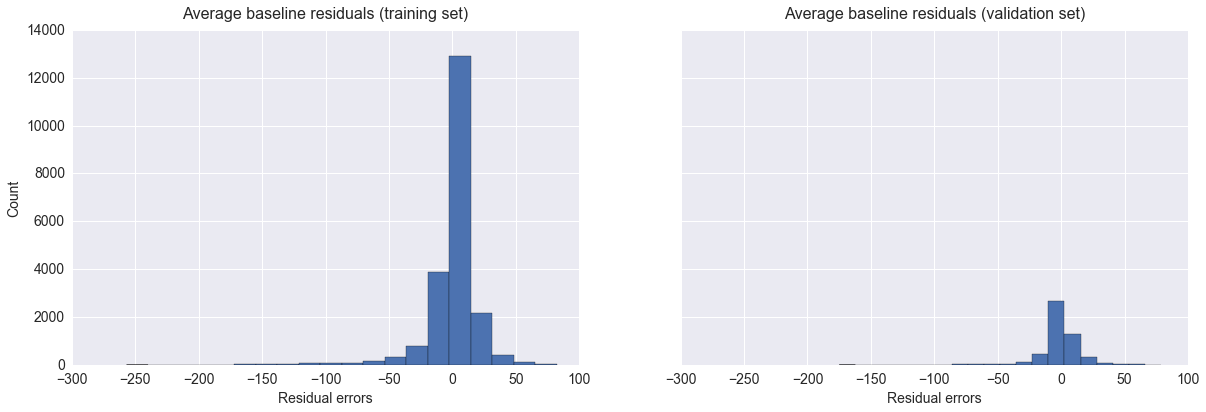

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from bcycle_lib.all_utils import df_from_results, plot_results, plot_val

reg = LinearRegression()
reg.fit(X_train, y_train)
y_train_pred = reg.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

y_val_pred = reg.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

scores_df = pd.DataFrame({'train_rmse' : train_rmse, 'val_rmse' : val_rmse}, index=['time_linreg'])


result_train_df, result_val_df = df_from_results(linreg_train_df.index, y_train, y_train_pred,
                                                 linreg_val_df.index, y_val, y_val_pred)

print('Linear reg baseline RMSE - Train: {:.2f}, Val: {:.2f}'.format(train_rmse, val_rmse))
plot_results(result_train_df, result_val_df, 'pred', 'true', title='Average baseline')



This is not a bad baseline model. Strangely, it gets a worse RMSE on the Training dataset than the validation dataset. This is probably because the data in 2014 is markedly lower than in 2015, and the validation set is somewhere in between. This implies I need to add some lagging indicators, as each hourly value is closely correlated with the ones that came before.

# Linear model with holiday and special events

As we saw when inspecting the data, there are quite a few peaks due to special events, and national holidays. Let's add in some dummy variables, so the model factors these into the result.

In [13]:
holidays = {'hol_new_year' : ('2014-01-01', '2015-01-01', '2016-01-01'),
            'hol_mlk' : ('2014-01-18', '2014-01-19','2014-01-20',
                         '2015-01-17', '2015-01-18','2015-01-19',
                         '2016-01-16', '2016-01-17','2016-01-18'),
            'hol_presidents' : ('2014-02-15', '2014-02-16', '2014-02-17',
                                '2015-02-14', '2015-02-15', '2015-02-16',
                                '2016-02-13', '2016-02-14', '2016-02-15'),
            'hol_memorial' : ('2014-05-24', '2014-05-25', '2014-05-26',
                              '2015-05-23', '2015-05-24', '2015-05-25',
                              '2016-05-28', '2016-05-29', '2016-05-30'),
            'hol_independence' : ('2014-07-04', '2014-07-05', '2014-07-06',
                                  '2015-07-03', '2015-07-04', '2015-07-05',
                                  '2016-07-02', '2016-07-03', '2016-07-04'),
            'hol_labor' : ('2014-08-30', '2014-08-31', '2014-09-01',
                           '2015-09-05', '2015-09-06', '2015-09-07',
                           '2016-09-03', '2016-09-04', '2016-09-05'),
            'hol_columbus' : ('2014-10-11', '2014-10-12', '2014-10-13',
                              '2015-10-10', '2015-10-11', '2015-10-12',
                              '2016-10-08', '2016-10-09', '2016-10-10'),
            'hol_veterans' : ('2014-11-11', '2015-11-11', '2016-11-11'),
            'hol_thanksgiving' : ('2014-11-27', '2014-11-28', '2014-11-29', '2014-11-30',
                                  '2015-11-26', '2015-11-27', '2015-11-28', '2015-11-29',
                                  '2016-11-24', '2016-11-25', '2016-11-26', '2016-11-27'),
            'hol_christmas' : ('2014-12-25', '2014-12-26', '2014-12-27', '2014-12-28',
                               '2015-12-25', '2015-12-26', '2015-12-27', '2015-12-28',
                               '2016-12-24', '2016-12-25', '2016-12-26', '2016-12-27')
           }


def add_date_indicator(df, col, dates):
    '''Adds a new indicator column with given dates set to 1
    INPUT: df - Dataframe
           col - New column name
           dates - Tuple of dates to set indicator to 1
    RETURNS: Dataframe with new column
    '''
    
    df[col] = 0
    for date in dates:
        if date in df.index:
            df.loc[date, col] = 1
            
    df[col] = df[col].astype(np.uint8)
    return df

a_df = train_df.copy()
for key, value in holidays.items():
    a_df = add_date_indicator(a_df, key, value)

# # train_df.head()

# df = train_df.copy()
# # df = add_date_indicator(df, 'hol_new_year', ('2014-01-01', '2015-01-01', '2016-01-01'))
# df = add_date_indicator(df, 'test_range', ['2014-01-01':'2014-01-03'])


# df.head(50)
                    

In [14]:
a_df[a_df['hol_christmas'] == 1]

,count,dayofweek,hour,day-hour,weekday,weekend,hol_veterans,hol_independence,hol_memorial,hol_new_year,hol_christmas,hol_thanksgiving,hol_columbus,hol_presidents,hol_labor,hol_mlk
datetime,,,,,,,,,,,,,,,,
2014-12-25 00:00:00,1,3,0,3-0,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 01:00:00,0,3,1,3-1,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 02:00:00,0,3,2,3-2,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 03:00:00,0,3,3,3-3,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 04:00:00,0,3,4,3-4,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 05:00:00,0,3,5,3-5,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 06:00:00,0,3,6,3-6,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 07:00:00,0,3,7,3-7,1,0,0,0,0,0,1,0,0,0,0,0
2014-12-25 08:00:00,0,3,8,3-8,1,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
train_df.loc[dates, 'test1'] = 1

In [ ]:
train_df.loc[dates]

In [ ]:
pd.date_range('2014-01-18', '2014-01-21')

# Processing Time and Date

First up is the date and time information. The `checkout_date` column is stored as a date in Excel, so it automatically converts it to `datetime` in pandas. But the `checkout_time` column is stored as text, so we need to convert it. 

After we combine the date and time, we can set this as the index of the dataframe which let us use all the next pandas timeseries functions.

In [ ]:
# Combine the date and time columns, use this as the index
def combine_date_time(df, new_col, date_col, time_col, set_index=True, drop=True):
    '''Combines `date_col` and `time_col` into a single datetime column
    INPUT: df - Dataframe to operate on
           date_col - string name of the date column
           time_col - string name of the time column
           set_index - bool whether to set as index after combining
           drop - bool whether to drop original columns afterwards
    RETURNS: Transformed dataframe
    '''

    if new_col != df.index.name:
        df[new_col] = pd.to_datetime(df[date_col] + ' ' + df[time_col])
        # trip_df = trip_df.sort_values('datetime')
        if set_index:
            df = df.set_index(new_col, drop=True)

        if drop:
            df = df.drop([date_col, time_col], axis=1)

    return df
    
trip_df = combine_date_time(trip_df, new_col='datetime', date_col='checkout_date', time_col='checkout_time')
print('Dataframe shape is {}'.format(trip_df.shape))
# print('Top rows:\n{}'.format(trip_df.head()))
# print('Bottom rows:\n{}'.format(trip_df.tail()))

print('Bikes dataframe date range from {} to {}'.format(trip_df.index[0], trip_df.index[-1]))

### Plotting weekly rentals

Let's plot the weekly rentals, to get a feel for how the data varies

In [ ]:
trip_df.resample('W').size().head()
plot_lines(trip_df.resample('W').size(), plt.subplots(1,1, figsize=(20,8)), 
           title='Weekly rentals', xlabel='', ylabel='Weekly rentals')

The rentals show that over the period of 3 years, the amount of rentals is increasing slightly, with 2014 rentals averaging around 3000 per week, 2015 is just under 4000, and 2016 is over 4000. There are also monthly variations, presumably due to the weather.

There are two obvious outliers in the rentals graph which happen every year around the same time. 

* The first is in mid-March, which corresponds to the [SXSW Festival](https://www.sxsw.com). This festival lasts for 7 - 10 days and is split between Interactive, Film, and Music tracks. The Interactive festival is centred on the Austin Convention Center, and during the Music section many venues all around the downtown area and East 6th Street play host to new bands. The peak rentals is ~14000 in both 2014 and 2015, dropping slightly to ~12000 in 2016.


* The second is in early October, when the [ACL Festival](https://www.aclfestival.com) happens. This is a huge music festival split over the first two weekends in October. The festival is held at Zilker Park. This peak is around ~6500 in 2014, increasing to just under 8000 in 2015 and 2016.

# Processing Memberships

The BCycle Membership scheme has been revamped several times during the course of the program. To keep the analysis simple, let's group the membership types into some simpler categories.

In [ ]:
# Let's see how many different types of membership there are
memberships_df = trip_df.groupby('membership').size()
print('Found {} different memberships:\n'.format(memberships_df.shape[0]))
print(memberships_df)

We'll use some regexes to combine the categories, to make it more readable I included '...' below to show it matches any following characters.

* `Single` <- 'Ridescout Single Ride', 'Try Before You Buy Special'
* `Day` <- '24-Hour ...', 'Explorer ...', 'Walk up ...'
* `Weekend` <- 'ACL Weekend Pass ...', 'FunFunFun ...', 'Weekender ...'
* `Weekly` <- '7-Day ...'
* `Monthly` <- 'Local30 ...'
* `Semester` <- 'Semester ...'
* `Annual` <- 'Annual ...', 'Local365 ...', 'Membership: pay once  one-year commitment', 'Republic Rider'
* `Tri-Annual` <- 'Founding Member ...'

There are a couple of other types labelled as `PROHIBITED` (8) and `RESTRICTED` (10). We'll drop these as there are only a small number of them, and many of these trips were 0 minutes long.

In [ ]:
def clean_memberships(df, col):
    '''Cleans memberships by consolidating and converting to categories
    INPUT: df - pandas Dataframe containing membership columns
           col - column name to be consolidated
    RETURNS: pandas DataFrame with consolidated memberships'''
    
    # Replace the various memberships with their groupings
    df[col] = df[col].astype(str)
    df[col] = df[col].replace(['RideScout Single Ride','Try Before You Buy Special'], value='single')
    df[col] = df[col].replace(['^24-Hour.*$', '^Explorer.*$', '^Walk Up$'], value='day', regex=True)
    df[col] = df[col].replace(['^ACL Weekend Pass.*$', '^FunFunFun.*$', '^Weekender.*$'], value='weekend', regex=True)
    df[col] = df[col].replace(['^7-Day.*$'], value='week', regex=True)
    df[col] = df[col].replace(['^Local30.*$'], value='month', regex=True)
    df[col] = df[col].replace(['^Semester.*$'], value='semester', regex=True)
    df[col] = df[col].replace(['^Annual.*$', '^Local365.*$', 'Republic Rider.*$', '^Membership: pay once  one-year.*$'], value='year', regex=True)
    df[col] = df[col].replace(['^Founding Member.*$', '^.*Founder.*$'], value='triannual', regex=True)

    # Drop the remaining trips (PROHIBITED and RESTRICTED)
    drop_mask = (df['membership'] == 'PROHIBITED') | (df['membership'] == 'RESTRICTED')
    df = df[~drop_mask]
    
    # Finally convert to categorical
    df[col] = df[col].astype('category')
    return df
    
trip_df = clean_memberships(trip_df, 'membership')

print(trip_df.groupby('membership').size())
print(trip_df.info())

### Visualizing membership types

Now we've converted all the many memberships into 8 final categories based on their length, we can visualize them more easily.

In [ ]:
# Show histogram of trip duration by membership type
# g = sns.FacetGrid(trip_df, row='membership', sharey=False, sharex=False, margin_titles=True, size=4)
# g.map(plt.hist, 'duration')
trip_df 

membership_order = ['single', 'day', 'weekend', 'week', 'month', 'semester', 'year', 'triannual']

def plot_boxplot(df, order, x, y, figsize, title, xlabel, ylabel):
    '''Plots a boxplot using given '''
    fig, ax = plt.subplots(1,1, figsize=figsize)  
    ax = sns.boxplot(data=df, x=x, y=y, order=order)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18})
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ttl = ax.title
    ttl.set_position([.5, 1.02])

# Log-transform the durations to compress range
trip_df['log_duration'] = trip_df['duration'].apply(np.log10)
plot_boxplot(trip_df, order=membership_order, x='membership', y='log_duration', figsize=(20,10),
            title='Trip duration by membership type', xlabel='Membership', ylabel='Trip duration (log10 minutes)')
# sns.boxplot(data=trip_df, x='membership', y='duration')

# g = sns.FacetGrid(tips, row="sex", col="time", margin_titles=True)
# bins = np.linspace(0, 60, 13)
# g.map(plt.hist, "total_bill", color="steelblue", bins=bins, lw=0)


Wow ! There are some huge ranges of trip durations here. Even after applying a log10 transformation to the values, there are still many outliers above the third quartile. This shows a heavily right-skewed distribution. There are also a lot of trips that are very short (0 in log10 units is 1 minute). These will need cleaning up.

Interestingly, the median length of trips and 1Q/3Q values decreases as the length of the membership goes up. This suggests people with a shorter membership make longer trips on average, and vice versa. The `single` membership has a 50% of the trips less than 10 minutes in length, perhaps because people were using a 'try-before-you-buy' special.

In [ ]:
# Show some of the longest trips
trip_df.sort_values('duration', ascending=False).head(10)

There are some common patterns to the ultra-long rentals. A lot of them have `Stolen` or `Missing` as their checkin kiosk, which shows they're not really trips but a way of recording theft. There are also some `Repair Shop`, `Shop`, and `Main Office` trips which are probably a bike needing maintenance.

These outliers should all be dropped by the time we have the dataset in a clean form below. We'll re-run this query again then, and make sure it looks better.

In [ ]:
# What are the stats for single memberships?
trip_df.loc[trip_df['membership'] == 'single', 'duration'].describe()

The single membership trip durations are very heavily right skewed. 25% of the trips are 1 minute or less (!) - either people with `single` memberships are **really** fast at cycling, or they're just taking a very short trip.

### Plotting trips by each membership type by year

Let's plot how the membership types vary over year. We'll use 2014, 2015, and 2016 as we have full years of data for these.

In [ ]:
# todo - Add in the trips by membership type
plot_df = trip_df.copy()
plot_df['year'] = plot_df.index.year
plot_df = plot_df['2014-01-01':'2016-12-31'].groupby(['year', 'membership']).size().reset_index(name='count')
plot_df = plot_df.pivot_table(index='year', columns='membership', values='count')
plot_df = plot_df.fillna(0)

def plot_bar(df, size, title, xlabel, ylabel):
    '''Plots a bar graph of the dataframe '''
    
    palette = sns.color_palette('Set2', len(df.columns)) # Don't repeat colours
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df.plot.bar(ax=ax, color=palette, rot=0)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.legend(fontsize = 14)

plot_bar(plot_df, (20,10), title='Trips by membership type and year', xlabel='Year', ylabel='Trip count')

This plot contains quite a bit of information. Remember this is the count of trips by membership type, not the amount of memberships that were sold of each type.

The first observation is that day memberships account for the vast majority of trips in every year, followed by the yearly memberships at around half the trip count, and then monthly memberships. Trips by other memberships are low compared to these. The trips by weekend members is growing rapidly from a small initial value.

# Processing Bike IDs

Now we need to convert the bike IDs to numeric values and convert to a categorical type. First of all let's check there aren't any non-numeric values in the dataset.

In [ ]:
# Find all the bike_id values that aren't numeric
print('Checking for non-numeric bike ids:')
text_row_mask = trip_df['bike_id'].str.contains('\D')
text_bikes_df = trip_df[text_row_mask]
bike_str_ids = text_bikes_df['bike_id'].unique()
print('Found non-numeric bike ids: {}'.format(bike_str_ids))


In [ ]:
# Check how many `bike_id`s are non-numeric and drop them
n_rows = trip_df.shape[0]
n_str_rows = np.sum(text_row_mask)
pct_str_rows = (n_str_rows / n_rows) * 100.0
print('Total rows: {}\n'.format(n_rows))
print('Total non-numeric `bike_id` values: {} or {:.1f}% of rows\n'.format(n_str_rows, pct_str_rows))
print('Non-numeric `bike_id` counts: \n{}'.format(text_bikes_df.groupby('bike_id').size()))

if n_str_rows != 0:
    trip_df = trip_df[~text_row_mask]
    assert np.sum(trip_df['bike_id'].str.contains('\D')) == 0, 'Error - still non-numeric bike_ids left !'
    
print('Max bike ID is {}'.format(trip_df['bike_id'].max()))
trip_df['bike_id'] = trip_df['bike_id'].astype(np.uint16)
trip_df.head()

In [ ]:
# Let's see how many times each of the bikes were rented out

def plot_hist(df_col, bins, size, title, xlabel, ylabel):
    '''Plots a histogram of the dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df_col.plot.hist(ax=ax, bins=bins)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   

bikes_df = trip_df.groupby('bike_id').size()
plot_hist(bikes_df, bins=50, size=(20,10), 
          title='Trip Count by Bike', 
          xlabel='Number of trips per Bike', 
          ylabel='Number of bikes')

bikes_df.describe()    

The histogram above shows that the most common number of trips for a given bike is around 1427. The distribution of trips per bike is left-skewed, with the Inter-Quartile-Range from 1264 to 1534 trips per bike. These bikes must be well maintained to make well over a thousand trips per bike !

# Processing stations

Now we need to convert the checkin and checkout kiosks into a categorical type instead of a string type. Let's do some checks to see what the overlap is like between checkin and checkout.

In [ ]:
# Create a set of all the checkout and checkin kiosks. 
# If the sizes are different we have some checkin or checkout only ones.
checkins = set(trip_df['checkin_kiosk'].unique())
checkouts = set(trip_df['checkout_kiosk'].unique())

print('Number of unique checkin kiosks: {}, checkout kiosks: {}'.format(len(checkins), len(checkouts)))

In [ ]:
# Hmm ! Let's see which stations are in checkin and checkout, and which are in one only

def venn_stats(left, right, verbose=False, left_name=None, right_name=None):
    '''Creates Venn Diagram stats for two sets, left and right
    INPUTS: left = set of items on left
            right = set of items on right
            verbose = bool to print out set overlap and count info
            left_name = string used if verbose == True. Describes left set
            right_name = string used if verbose == True. Describes right set
    '''
    left_only = left - right
    left_and_right = left & right
    right_only = right - left
    
    if verbose:
        print('{} size = {}, {} size = {}'.format(left_name, len(left), right_name, len(right)))
        print('\nIntersection of {} and {} ({}):\n{}'.format(left_name, right_name, len(left_and_right), left_and_right))
        print('\n{}-only ({}):\n{}'.format(left_name, len(left_only), left_only))
        print('\n{}-only ({}):\n{}'.format(right_name, len(right_only), right_only))

    return (left_only, left_and_right, right_only)

venn_stations = venn_stats(checkouts, checkins, 
                          verbose=True, left_name='checkout', right_name='checkin')

checkout_only_stations, common_stations, checkin_only_stations = venn_stations

### Checkout-only stations

Let's see how many trips stations only found in the `checkout_kiosk` columns. If there are only a small proportion, we can drop these. Otherwise we need to include them (but there's no obvious reason why a station would be checkin or checkout only).

In [ ]:
# Let's deal with the checkin and checkout only stations
checkout_only_mask = trip_df['checkout_kiosk'].isin(checkout_only_stations)
checkout_only_count = np.sum(checkout_only_mask)
all_rows_count = trip_df.shape[0]
checkout_only_pct = (checkout_only_count / all_rows_count) * 100.0
checkout_only_df = trip_df[checkout_only_mask]
print('Number of checkout-only rows: {}, {:.4f}% of total'.format(checkout_only_count, checkout_only_pct))

if checkout_only_count > 0:
    trip_df = trip_df[~checkout_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkout_only_df.groupby('checkout_kiosk').size()

The stations above are only in the `checkout_kiosk` column, and never in the `checkin_kiosk` column. There are only 8 rows, which all leave from 'Fantasy Zilker' in the first 2 weekends of October 2016. I suspect this might be a special event held in Zilker Part. As there are only 8 of these rows, we can drop them from the dataset.

### Checkin-only stations

Now we can see which station names are only in the `checkin_kiosk` column, and not the `checkout_kiosk` column. It's hard to think of a reason why trips would only end at a station, and not begin from the same one over the course of multiple years. 

In [ ]:
checkin_only_mask = trip_df['checkin_kiosk'].isin(checkin_only_stations)
checkin_only_count = np.sum(checkin_only_mask)
all_rows_count = trip_df.shape[0]
checkin_only_pct = (checkin_only_count / all_rows_count) * 100.0
checkin_only_df = trip_df[checkin_only_mask]
print('Number of checkin-only rows: {}'.format(checkin_only_df.shape[0]))

if checkin_only_count > 0:
    trip_df = trip_df[~checkin_only_mask]
print('Trips Dataframe shape is {}'.format(trip_df.shape))
checkin_only_df.groupby('checkin_kiosk').size()

There are only 69 checkin-only rows, from one of the three types: Main Shop, Missing, and Stolen. I think the 'Main Shop' ones might have been returned to the BCycle maintenance office for repair. Stolen bikes are self explanatory, the 'Missing' ones must be the ones that have gone missing, but not yet returned. We can drop these rows.

## Counting checkins and checkouts at stations

Now we're left with only stations that are in both the checkout and checkin columns on the full dataset. We can count up all the checkins and checkouts at each of the stations. Then we can sum up the totals by station. Let's create this dataframe, and then create a barplot to see how the checkouts and checkins vary by station.

In [ ]:
# Now all stations are common in checkin and checkout
checkouts_df = trip_df.groupby('checkout_kiosk').size().to_frame('checkouts').reset_index()
checkins_df = trip_df.groupby('checkin_kiosk').size().to_frame('checkins').reset_index()
station_df = pd.merge(checkins_df, checkouts_df, left_on='checkin_kiosk', right_on='checkout_kiosk')
station_df = station_df.drop('checkout_kiosk', axis=1)
station_df.columns = ['name', 'checkins', 'checkouts']
station_df['total'] = station_df['checkins'] + station_df['checkouts']
station_df = station_df.sort_values('total', ascending=False).reset_index(drop=True)
station_df.head()

In [ ]:
# Create a bar plot of the checkins and checkouts per station
def plot_bar(df, x, y, size, title, xlabel, ylabel):
    '''Plots a bar-graph of dataframe column'''
    
    fig, ax = plt.subplots(1, 1, figsize=size)
    ax = df.plot.bar(ax=ax, x=x, y=y)
    ax.set_xlabel(xlabel, fontdict={'size' : 14})
    ax.set_ylabel(ylabel, fontdict={'size' : 14})
    ax.set_title(title, fontdict={'size' : 18}) 
    ttl = ax.title
    ttl.set_position([.5, 1.02])
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)   
    ax.legend(fontsize = 14)


plot_bar(station_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Checkins and checkouts by station',
        xlabel='Station', ylabel='Checkins / Checkouts')


This is a very busy plot, and too condensed to easily read the station names. But you can see the rough distribution of checkins and checkouts from the busiest stations (City Hall, Riverside @ S. Lamar, 2nd & Congress, etc) down to the quietest stations ('Marketing Event', 'Mobile Station @ Boardwalk Opening', 'Re-branding'). As you get to the quieter stations, they seem to be temporary stations at events, or codenames for maintenance on the bikes: 'Shop'.

In [ ]:
# Now let's print out all the stations, and drop ones which seem temporary

def remove_rows(df, col, words, verbose=False):
    '''Removes rows containing words given
    INPUT: df - dataframe
           words - iterable containing words
    RETURNS: Dataframe with rows containing `words` removed
    '''
    new_df = df.copy()
    for word in words:
        drop_mask = new_df[col].str.contains(word)
        drop_count = np.sum(drop_mask)
        drop_df = new_df[drop_mask]
        print('Dropping {} rows containing {}:\n{}'.format(drop_count, word, drop_df[col]))
        if (drop_count > 0):
            new_df = new_df[~drop_mask]
    return new_df.reset_index(drop=True)


station_df = remove_rows(station_df, 'name', 
                 ['MapJam', 'Mobile', 'Shop', 'Marketing', 'Re-branding', 
                  'Customer Service', 'Main Office'],
                 verbose=True)
station_df = station_df.sort_values('name').reset_index(drop=True)
station_df['station_id'] = range(station_df.shape[0])
station_df['station_id'] = station_df['station_id'] + 1
station_df.head()

### Re-ploting checkins and checkouts by station (after dropping invalid stations)

Let's redo the previous bar plot now we dropped the temporary stations and `Shop`, `Repair Shop`, and `Main Office` rows.

In [ ]:
station_df = station_df.sort_values('total', ascending=False)
plot_bar(station_df, x='name', y=['checkins', 'checkouts'], size=(20,10), 
         title='Checkins and checkouts by station',
        xlabel='Station', ylabel='Checkins / Checkouts')

# Adding metadata to stations dataframe

Now we have the stations table separated from the trips, we can add in metadata for the longitude and latitude of each of the stations. These can come from a combination of:

* The Austin Bcycle station: This can be parsed to extract the stations and matched based on the names.
* Google's geocoder: We can fill in any stations not currently on the webpage using geocoding.

In [ ]:
import requests
import re

def parse_stations_html(url, verbose=False):
    '''Parses an HTML file at url, returning a dictionary of matches
    INPUT: url string to parse
    RETURNS: dictionary with lat/lon key, and station info as value
    '''
    LAT_IDX = 0
    LONG_IDX = 1

    STAT_NAME = 0
    STAT_ADDRESS = 1
    STAT_BIKES = 2
    STAT_DOCKS = 3
    
    date_re = re.compile('.*stations_(\d{4}-\d{2}-\d{2}).*\.html')
    time_re = re.compile('.*stations_\d{4}-\d{2}-\d{2}_(\d{2}:\d{2}:)\d{2}.*\.html')
    # The `Convention Center / 4th St. @ MetroRail` station has a bug in the HTML.
    station_re = re.compile('^var marker = new createMarker\(point, \"<div class=\'markerTitle\'>'
                            '<h3>(\w.*)</h3></div><div class=\'markerPublicText\'><.+></div>'
                            '<div class=\'markerAddress\'>(\w.*)</div><div class=\'markerAvail\'>'
                            '<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Bikes</div>'
                            '<div style=\'float: left; width: 50%\'><h3>(\d+)</h3>Docks</div></div>\".*$')
    latlong_re = re.compile('var point = new google\.maps\.LatLng\((.+), (.+)\);')

    # Dictionary to store stations
    stations = dict()
    
    r = requests.get(url, stream=True)

    location_count = 0
    station_count = 0
    lat = -1
    lon = -1
    def parse_latlon(line, regex):
        '''Helper function to parse latitude and longitude to tuple'''
        match = regex.match(line)
        if (match != None):
            latitude = float(regex.match(line).groups()[LAT_IDX])
            longitude = float(regex.match(line).groups()[LONG_IDX])
            latlon = (latitude, longitude)
            return latlon
        return None

    def parse_station(line, regex):
        '''Helper function to parse station info into dict'''
        
        match = regex.match(line)
        if (match != None):
            name = str(regex.match(line).groups()[STAT_NAME])
            address = str(regex.match(line).groups()[STAT_ADDRESS].replace('<br />', ', '))
            bikes = int(regex.match(line).groups()[STAT_BIKES])
            docks = int(regex.match(line).groups()[STAT_DOCKS])

            new_station = dict()
            new_station['name'] = name
            new_station['address'] = address
            return new_station
        
        return None
            
        
    for line in r.iter_lines():
        if line:
            decoded_line = line.decode('utf-8')
            
            latlon = parse_latlon(decoded_line, latlong_re)
            if latlon is not None:
                location_count += 1
                lat, lon = latlon
                if verbose:
                    print('Found location {}: lat {}, lon {}'.format(location_count, latlon[0], latlon[1]))
                continue
                
            new_station = parse_station(decoded_line, station_re)
            if new_station is not None:
                station_count += 1
                new_station['lat'] = lat
                new_station['lon'] = lon
                stations[station_count] = new_station
                if verbose:
                    print('Adding station #{}, {}'.format(station_count, new_station['name']))

    assert station_count == location_count, 'Error - found {} locations, {} stations'.format(station_count, location_count)
    return stations
                    
web_stations = parse_stations_html('https://austin.bcycle.com/stations/station-locations', verbose=False)

web_stations_df = pd.DataFrame.from_dict(web_stations, orient='index')
web_stations_df = web_stations_df.reset_index()
web_stations_df = web_stations_df.rename(columns={'index' : 'station_id'})
web_stations_df = web_stations_df[['station_id', 'name', 'address', 'lat', 'lon']]
print('Current website contains {} stations. Top 6:'.format(web_stations_df.shape[0]))
web_stations_df.head()

### Looking up remaining station locations

There are dozens of stations in from the full data bike trip which aren't on the current website. These might be older stations which were shut down, or ones which changed name and moved. We need to fill in both a latitude and longitude, as well as an address. We can fill in this missing info using geocoding. 

First of all, let's split the list of all the stations in the bike trips full data into those:

* Which we found information on by scraping the current bicycle location page
* For which we have the name only, not the location information

In [ ]:
# Create a dataframe of stations which are in the bike trips DF but not on website
all_stations_df = station_df.copy()
missing_stations_df = all_stations_df[~all_stations_df['name'].isin(web_stations_df['name'])]
missing_stations_df = missing_stations_df['name'].reset_index()

# Number the missing stations starting from the last web scraped one
start_index = web_stations_df.shape[0] + 1
stop_index = start_index + missing_stations_df.shape[0]
missing_station_ids = range(start_index, stop_index)
missing_stations_df['station_id'] = missing_station_ids
missing_stations_df = missing_stations_df[['station_id', 'name']]
print('There are {} missing stations'.format(missing_stations_df.shape[0]))
missing_stations_df

In [ ]:
from pygeocoder import Geocoder
import re

def geocode(name, verbose=False, dry_run=False):
    '''Tries to geocode a location, returns None if no matches
    INPUT: name - string containing the location
    RETURNS: tuple of (latitude, longitude) if successful, None if not
    '''

    name = re.sub('^ACC - ', '', name)
    name = re.sub('^West & ', 'West Ave & ', name)
    name = re.sub('at the \D.*$', '', name)
    name = re.sub('^Convention Center/', '', name)
    name = re.sub('^State Parking Garage @', '', name)
    name = re.sub('Zilker Park West', 'Zilker Park', name)

    for end in ('rd', 'st', 'th'):
        name = re.sub(end + '$', end + ' Street', name)

    name += ', Austin TX' # Add this on the end to help !
    
    if dry_run:
        print('Looking up {}'.format(name))
        return name
    
    try:
        result = Geocoder.geocode(name)
        if verbose:
            print('Returned {} geocode as {}'.format(name, result.coordinates))
        return result.coordinates
    
    except Exception as e:
        print('** Error finding geocode for {}'.format(name))
        return None

missing_stations_df['latlon'] = missing_stations_df['name'].apply(lambda x: geocode(x, verbose=True))
missing_stations_df

## Checking geocodes on a map

Now we have geocoded all the stations that aren't on the current BCycle website, we can plot them on a map to sanity check them. The markers are clickable, showing their address.

In [ ]:
import folium

def split_position(df, tuple_col, lat_col, lon_col, drop=True):
    '''Splits a (latitude, longitude) tuple into separate columns
    INPUT: df - dataframe to operate on
           tuple_col - name of the (lat, lon) tuple column
           lat_col - name of the new split latitude column
           lon_col - name of the new split longitude column
    RETURNS: Dataframe with new columns
    '''
    if tuple_col in df.columns:
        df[lat_col] = df[tuple_col].apply(lambda x: x[0])
        df[lon_col] = df[tuple_col].apply(lambda x: x[1])
        if drop:
            df = df.drop(tuple_col, axis=1)
    return df

def map_plot(df, verbose=False):
    '''Plots stations on a map from a dataframe'''
    min_lat = df['lat'].min()
    max_lat = df['lat'].max()
    min_lon = df['lon'].min()
    max_lon = df['lon'].max()
    center_lat = min_lat + (max_lat - min_lat) / 2.0
    center_lon = min_lon + (max_lon - min_lon) / 2.0
    if verbose:
        print('Plotting map centred at ({}, {})'.format(center_lat, center_lon))
    
    # Plot map using the B&W Stamen Toner tiles centred on BCycle stations
    map = folium.Map(location=(center_lat, center_lon), zoom_start=14, 
                     tiles='Stamen Toner', control_scale=True)

    # Add markers to the map for each station. Click on them to see their name
    for station in df.iterrows():
        stat=station[1]
        folium.Marker([stat['lat'], stat['lon']], popup=stat['name'],
                  icon=folium.Icon(icon='info-sign')
                 ).add_to(map)

    map.save('stations.html')
    return map
    
map_plot(split_position(missing_stations_df, 'latlon', 'lat', 'lon'))

### Reverse geocoding to find address from latitude and longitude

Now we have latitude and longitude, we can convert this back into an address. Then all the stations not scraped from the site have the same data as the ones from the site.

In [ ]:
def rev_geocode(latlon, verbose=False):
    '''Tries to reverse geocode a latitude and longitude, returns None if no matches
    INPUT: latlon - 2-tuple containing (latitude, longitude)
    RETURNS: String with address if found
    '''
    try:
        result = Geocoder.reverse_geocode(latlon[0], latlon[1])
        if verbose:
            print('Returned {} geocode as {}'.format(latlon, result))
        return result
    
    except Exception as e:
        print('** Error finding geocode for {}: {}'.format(latlon, e))
        return None

missing_stations_df['address'] = missing_stations_df['latlon'].apply(lambda x: rev_geocode(x, verbose=True))
missing_stations_df.head()

### Splitting latitude and longitude, recombining into web_stations

In [ ]:
missing_stations_df = split_position(missing_stations_df, 'latlon', 'lat', 'lon')
missing_stations_df.head()

### Combining stations back together into single table

In [ ]:
all_stations_df = pd.concat((web_stations_df, missing_stations_df), axis=0)
all_stations_df = all_stations_df.reset_index(drop=True)
print('All stations count: {}'.format(all_stations_df.shape[0]))
all_stations_df.head()

# Normalizing bikes and trips into separate tables

Now we have a clean list of stations, we can use their `station_id` values to link them to the bike trips table. We expect some bike trips to be dropped, as we removed their stations from the cleaned dataframe.

In [ ]:
n_trips = trip_df.shape[0]
print('Before normalizing, bikes_df has {} rows'.format(n_trips))
stations = set(all_stations_df['name'])
print('{} stations in station table'.format(len(stations)))


def venn_stats_df(df, left_col, right_col, verbose=False):
    '''Creates Venn Diagram stats for two sets, left and right
    INPUTS: df - Dataframe with columns to check for overlaps
            left_col = Dataframe column to use as left items
            right_col = Dataframe column to use as right items
            verbose = bool to print out set overlap and count info
    '''
    left = set(df[left_col].unique())
    right = set(df[left_col].unique())

    left_only = left - right
    left_and_right = left & right
    right_only = right - left
    
    if verbose:
        print('{} size = {}, {} size = {}'.format(left_col, len(left), right_col, len(right)))
        print('\nIntersection of {} and {} ({}):\n{}'.format(left_col, right_col, len(left_and_right), left_and_right))
        print('\n{}-only ({}):\n{}'.format(left_col, len(left_only), left_only))
        print('\n{}-only ({}):\n{}'.format(right_col, len(right_only), right_only))

    return (left_only, left_and_right, right_only)

l, m, r = venn_stats_df(trip_df, left_col='checkin_kiosk', right_col='checkout_kiosk', verbose='True')
bike_stations = m

l, m, r = venn_stats(bike_stations, stations, left_name='bike_stations', right_name='station_table', verbose=True)
bike_stations_only = l

bike_stations_only_checkin_mask = trip_df['checkin_kiosk'].isin(bike_stations_only)
bike_stations_only_checkout_mask = trip_df['checkout_kiosk'].isin(bike_stations_only)
bike_stations_only_mask = bike_stations_only_checkin_mask | bike_stations_only_checkout_mask
bike_stations_only_count = np.sum(bike_stations_only_mask)
n_dropped_trips = n_trips - bike_stations_only_count

print('Pre-normalize row count: {}, post-normalize: {}'.format(n_trips, n_dropped_trips))

### Final table splitting and replacement with `station_id` 

In [ ]:
norm_trip_df = pd.merge(trip_df.reset_index(), all_stations_df[['name', 'station_id']], left_on='checkout_kiosk', right_on='name')
norm_trip_df = pd.merge(norm_trip_df, all_stations_df[['name', 'station_id']], left_on='checkin_kiosk', right_on='name')
norm_trip_df = norm_trip_df[['datetime', 'membership', 'bike_id', 'station_id_x', 'station_id_y', 'duration']]
norm_trip_df = norm_trip_df.rename(columns={'station_id_x' : 'checkout_id', 'station_id_y' : 'checkin_id'})
norm_trip_df = norm_trip_df.sort_values('datetime')
norm_trip_df = norm_trip_df.set_index('datetime', drop=True)
# norm_trip_df
      
print('After normalizing, bikes_df has {} rows'.format(norm_trip_df.shape[0]))
print('\nNull columns report:\n{}'.format(norm_trip_df.isnull().sum()))

In [ ]:
# import _pickle as cPickle

# Save out the trips and stations dataframe
norm_trip_df.to_csv('../input/all_trips_clean.csv')
all_stations_df.to_csv('../input/all_stations_clean.csv', index=False)

In [ ]:
norm_trip_df.info()